In [1]:
from Models import Classification_Module as Classification_Module
from Models import Focus_Module as Focus_Module
from Mosaic import mosaic_data, MosaicDataset,split_foreground_background
from torch.utils.data import Dataset,DataLoader
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from matplotlib import pyplot as plt
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda
cuda


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
data = split_foreground_background(trainloader,total = 50000)
mosaic_list_of_images,mosaic_label,fore_idx = mosaic_data(data,desired_num=30000,total=50000)

In [0]:
batch = 250
train_dataset  = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
mosaic_loader = DataLoader( train_dataset,batch_size= batch ,shuffle=True)

In [0]:
mimages_val,mlabel_val,fidx_val = mosaic_data(data,desired_num=10000,total=50000)

In [0]:
batch = 250
test_dataset  = MosaicDataset(mimages_val,mlabel_val,fidx_val)
test_loader = DataLoader( test_dataset,batch_size= batch ,shuffle=True)

In [0]:
focus_net =  Focus_Module(3,1).double()
focus_net = focus_net.to(device)

In [0]:
classification_net  = Classification_Module(3,3).double()


In [9]:

classification_net = classification_net.to(device)
classification_net

Classification_Module(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 8, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=3, bias=True)
)

In [0]:
optimizer_focus = optim.SGD(focus_net.parameters(),lr = 0.01,momentum=0.9)
optimizer_classification = optim.SGD(classification_net.parameters(),lr =0.01, momentum=0.9)

In [0]:

criterion = nn.CrossEntropyLoss()

In [12]:
tr_loss = []
for epoch in range(110):  # loop over the dataset multiple times
    running_loss = 0.0
    cnt=0
    iteration = 30000 // batch
    ep_loss = []
    for i, data in  enumerate(mosaic_loader):
        inputs , labels , fgrnd_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda")
        optimizer_focus.zero_grad()
        optimizer_classification.zero_grad()
        avg_data , alphas = focus_net(inputs)
        outputs = classification_net(avg_data)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_focus.step()
        optimizer_classification.step()

        running_loss += loss.item()
        mini = 40
        if cnt % mini == mini-1:    # print every mini mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
            ep_loss.append(running_loss/mini)
            running_loss = 0.0  
        cnt=cnt+1
    tr_loss.append(np.mean(ep_loss))      
print('Finished Training')    

[1,    40] loss: 1.100
[1,    80] loss: 1.099
[1,   120] loss: 1.099
[2,    40] loss: 1.099
[2,    80] loss: 1.099
[2,   120] loss: 1.099
[3,    40] loss: 1.099
[3,    80] loss: 1.099
[3,   120] loss: 1.099
[4,    40] loss: 1.098
[4,    80] loss: 1.099
[4,   120] loss: 1.098
[5,    40] loss: 1.099
[5,    80] loss: 1.098
[5,   120] loss: 1.098
[6,    40] loss: 1.098
[6,    80] loss: 1.098
[6,   120] loss: 1.098
[7,    40] loss: 1.098
[7,    80] loss: 1.098
[7,   120] loss: 1.098
[8,    40] loss: 1.097
[8,    80] loss: 1.097
[8,   120] loss: 1.097
[9,    40] loss: 1.096
[9,    80] loss: 1.095
[9,   120] loss: 1.093
[10,    40] loss: 1.091
[10,    80] loss: 1.089
[10,   120] loss: 1.086
[11,    40] loss: 1.086
[11,    80] loss: 1.081
[11,   120] loss: 1.080
[12,    40] loss: 1.078
[12,    80] loss: 1.083
[12,   120] loss: 1.078
[13,    40] loss: 1.079
[13,    80] loss: 1.075
[13,   120] loss: 1.073
[14,    40] loss: 1.074
[14,    80] loss: 1.071
[14,   120] loss: 1.072
[15,    40] loss: 1

In [14]:
  train_acc = 0
for i, data in enumerate(mosaic_loader):
    inputs,labels,_ = data
    inputs,labels = inputs.to(device), labels.to(device)
    
    avg_data,alphas = focus_net(inputs)
    outputs = classification_net(avg_data)
    _,predicted = torch.max(outputs.data,1)
    # print(predicted.detach().cpu().numpy())
    train_acc += sum(predicted.cpu().numpy() == labels.cpu().numpy())
print("percentage train accuracy: ",train_acc/300) 

torch.save(focus_net.state_dict(),"focus_net_at_zero.pt")
torch.save(classification_net.state_dict(),"classification_net_at_zero.pt")

percentage train accuracy:  96.68333333333334


In [15]:
val_acc = 0
for i, data in enumerate(test_loader):
    inputs,labels,_ = data
    inputs,labels = inputs.to(device), labels.to(device)

    avg_data,alphas = focus_net(inputs)
    outputs = classification_net(avg_data)
    _,predicted = torch.max(outputs.data,1)

    val_acc +=sum(predicted.cpu().numpy() == labels.cpu().numpy())
print("percentage validation accuracy: ",val_acc/100)

percentage validation accuracy:  85.98


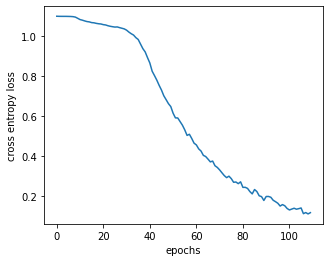

In [17]:
plt.figure(figsize = (5,4))
plt.plot(tr_loss,label= "training loss")
plt.xlabel("epochs")
plt.ylabel("cross entropy loss")
plt.savefig("training_loss_at_zero.png")
plt.savefig("training_loss_at_zero.pdf")